In [1]:
import torch
import os
import numpy as np
from hmc_u1 import HMC_U1
from hmc_u1_ft import HMC_U1_FT
from cnn_model import FieldTransformation
from utils import hmc_summary


In [2]:
# Parameters
lattice_size = 32
volume = lattice_size ** 2
beta = 8
n_thermalization_steps = 200
n_steps = 50
step_size = 0.07
n_iterations = 1024

# Initialize device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

# Set default type
torch.set_default_dtype(torch.float32)

### No Field Transformation

>>> No Field Transformation HMC Simulation: 


Running HMC: 100%|██████████| 1024/1024 [00:12<00:00, 82.35it/s]


>>> Simulation completed


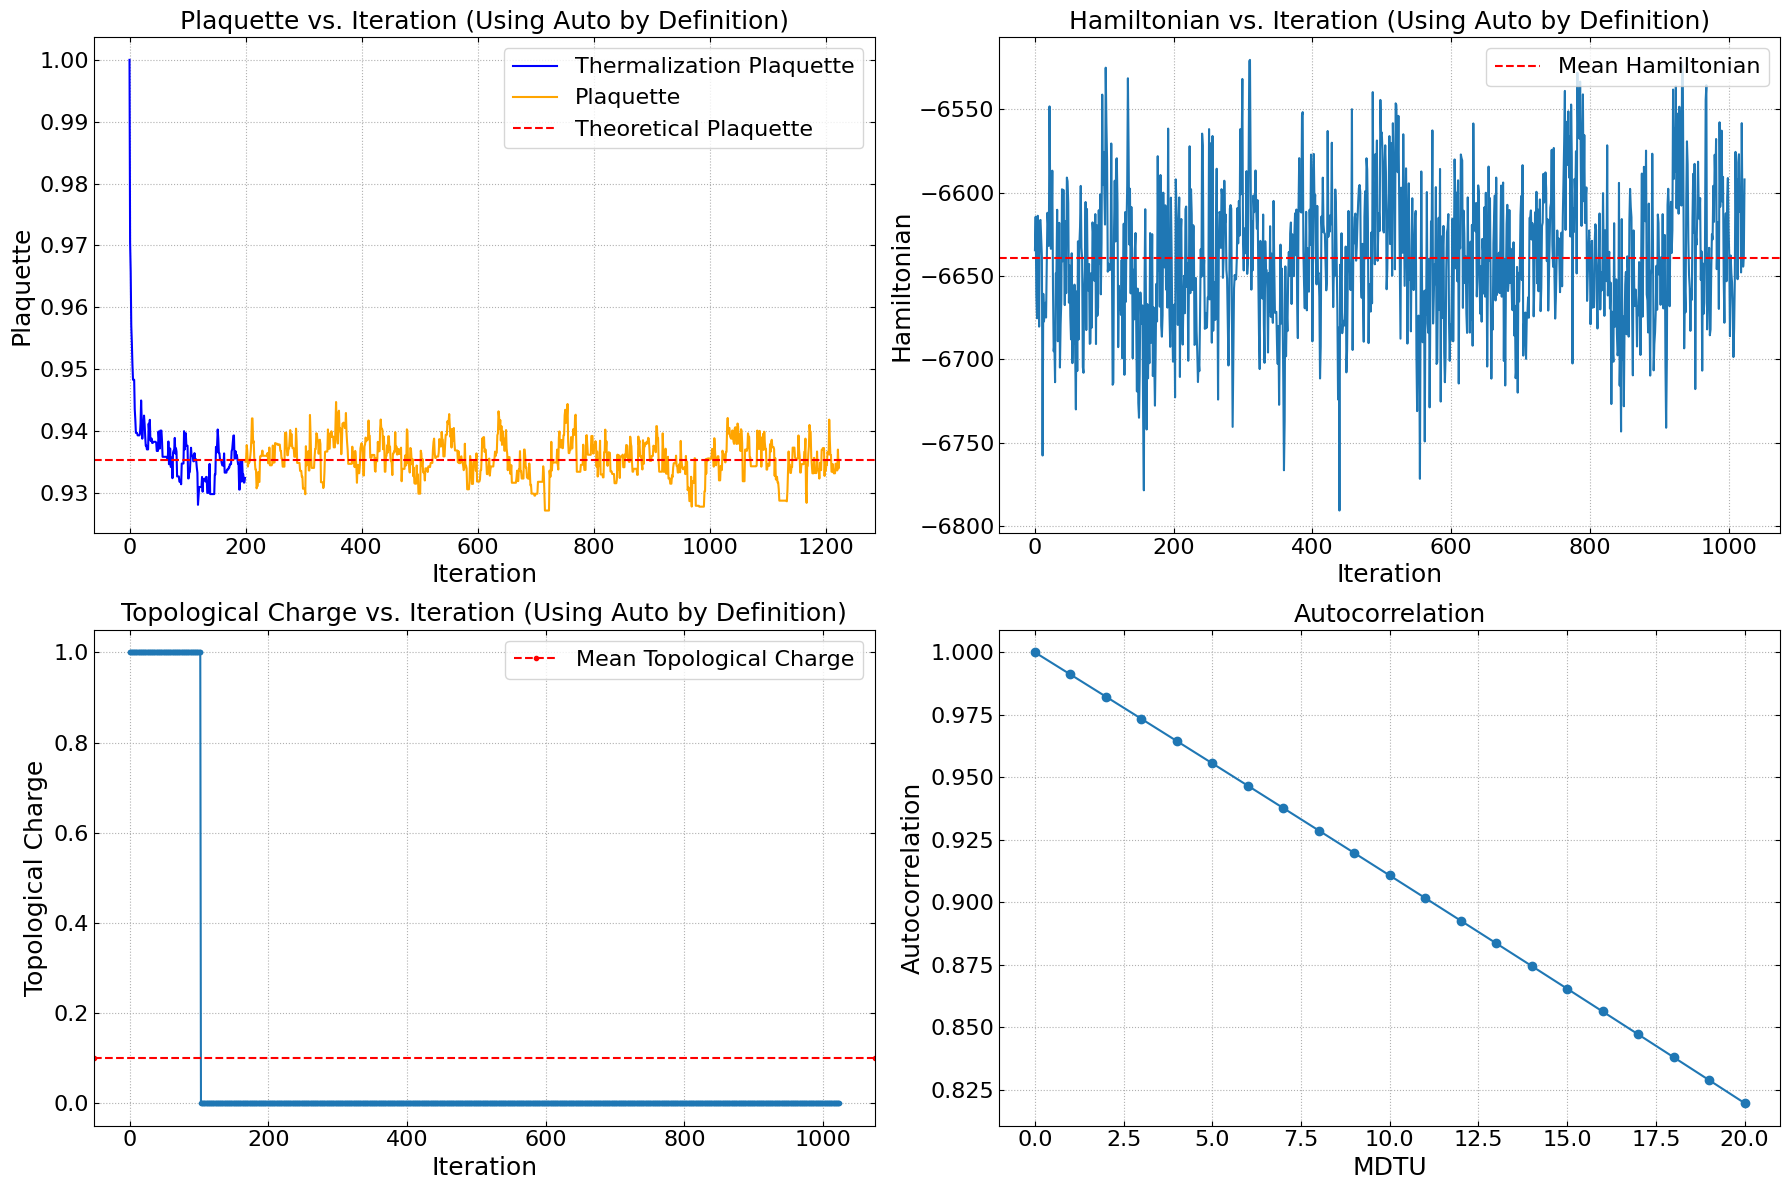

>>> Theoretical plaquette:  0.9352354935294382
>>> Mean plaq:  0.935391700884793
>>> Std of mean plaq:  9.672583889653185e-05
Thermalization acceptance rate: 0.6100
Acceptance rate: 0.6230


In [3]:
print(">>> No Field Transformation HMC Simulation: ")

# Initialize HMC
hmc = HMC_U1(lattice_size, beta, n_thermalization_steps, n_steps, step_size, device=device)

# Thermalize the system
theta_thermalized, therm_plaq_ls, therm_acceptance_rate = hmc.thermalize()

# Run HMC without field transformation
config_ls, plaq_ls, acceptance_rate, topological_charges, hamiltonians = hmc.run(n_iterations, theta_thermalized)

print(">>> Simulation completed")


# Compute autocorrelation of topological charges
max_lag = 20
hmc_fig = hmc_summary(beta, max_lag, volume, therm_plaq_ls, plaq_ls, topological_charges, hamiltonians, therm_acceptance_rate, acceptance_rate)
hmc_fig.savefig(f'plots/hmc_L{lattice_size}_beta{beta}.pdf', transparent=True)

# Save configurations for training
np.save(f'dump/theta_ori_L{lattice_size}_beta{beta}.npy', torch.stack(config_ls).detach().cpu().numpy())


### Neural Network Field Transformation

>>> Neural Network Field Transformation HMC Simulation: 


/home/jinchen/miniconda3/envs/lat/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Loaded data shape: torch.Size([1024, 2, 32, 32])
Training data shape: torch.Size([819, 2, 32, 32])
Testing data shape: torch.Size([205, 2, 32, 32])
>>> Training the model


Training epochs:   6%|▋         | 1/16 [03:09<47:28, 189.93s/it]

Epoch 1/16 - Train Loss: 50.465189 - Test Loss: 34.852548


Training epochs:  12%|█▎        | 2/16 [06:24<44:53, 192.41s/it]

Epoch 2/16 - Train Loss: 25.074763 - Test Loss: 15.511498


Training epochs:  19%|█▉        | 3/16 [09:41<42:13, 194.90s/it]

Epoch 3/16 - Train Loss: 11.871993 - Test Loss: 8.572517


Training epochs:  25%|██▌       | 4/16 [13:01<39:22, 196.85s/it]

Epoch 4/16 - Train Loss: 7.366640 - Test Loss: 6.201142


Training epochs:  31%|███▏      | 5/16 [16:21<36:17, 197.97s/it]

Epoch 5/16 - Train Loss: 5.869532 - Test Loss: 5.360435


Training epochs:  38%|███▊      | 6/16 [19:41<33:06, 198.69s/it]

Epoch 6/16 - Train Loss: 5.289578 - Test Loss: 4.986292


Training epochs:  44%|████▍     | 7/16 [23:01<29:52, 199.11s/it]

Epoch 7/16 - Train Loss: 4.951160 - Test Loss: 4.737806


Training epochs:  50%|█████     | 8/16 [26:23<26:39, 199.90s/it]

Epoch 8/16 - Train Loss: 4.733829 - Test Loss: 4.567414


Training epochs:  56%|█████▋    | 9/16 [29:45<23:24, 200.58s/it]

Epoch 9/16 - Train Loss: 4.589764 - Test Loss: 4.456206


Training epochs:  62%|██████▎   | 10/16 [33:09<20:09, 201.51s/it]

Epoch 10/16 - Train Loss: 4.505579 - Test Loss: 4.352568


Training epochs:  69%|██████▉   | 11/16 [36:32<16:50, 202.18s/it]

Epoch 11/16 - Train Loss: 4.393090 - Test Loss: 4.276215


Training epochs:  75%|███████▌  | 12/16 [39:54<13:28, 202.20s/it]

Epoch 12/16 - Train Loss: 4.317957 - Test Loss: 4.217480


Training epochs:  81%|████████▏ | 13/16 [43:18<10:07, 202.45s/it]

Epoch 13/16 - Train Loss: 4.223725 - Test Loss: 4.169812


Training epochs:  88%|████████▊ | 14/16 [46:41<06:45, 202.69s/it]

Epoch 14/16 - Train Loss: 4.192046 - Test Loss: 4.131842


Training epochs:  94%|█████████▍| 15/16 [50:03<03:22, 202.52s/it]

Epoch 15/16 - Train Loss: 4.156203 - Test Loss: 4.082515


Training epochs: 100%|██████████| 16/16 [53:26<00:00, 200.39s/it]

Epoch 16/16 - Train Loss: 4.111002 - Test Loss: 4.061845


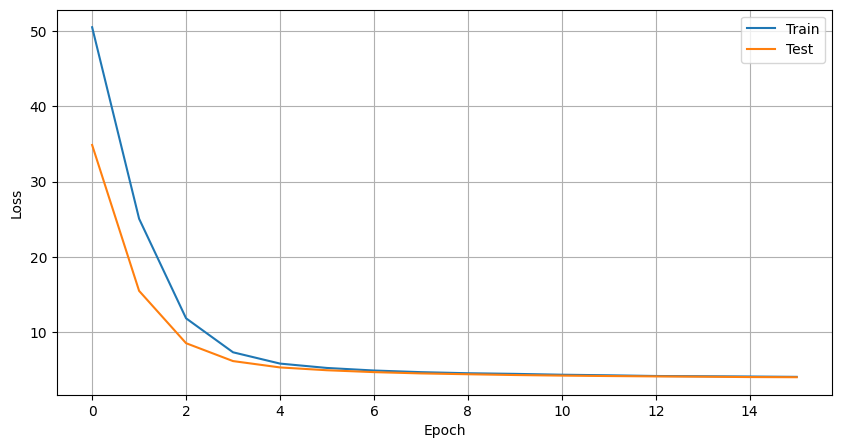

Loaded best models from epoch 15 with loss 4.061845
>>> Loading the trained models
Loaded best models from epoch 15 with loss 4.061845
>>> Models loaded successfully


Running HMC: 100%|██████████| 1024/1024 [39:52<00:00,  2.34s/it]


>>> Simulation completed


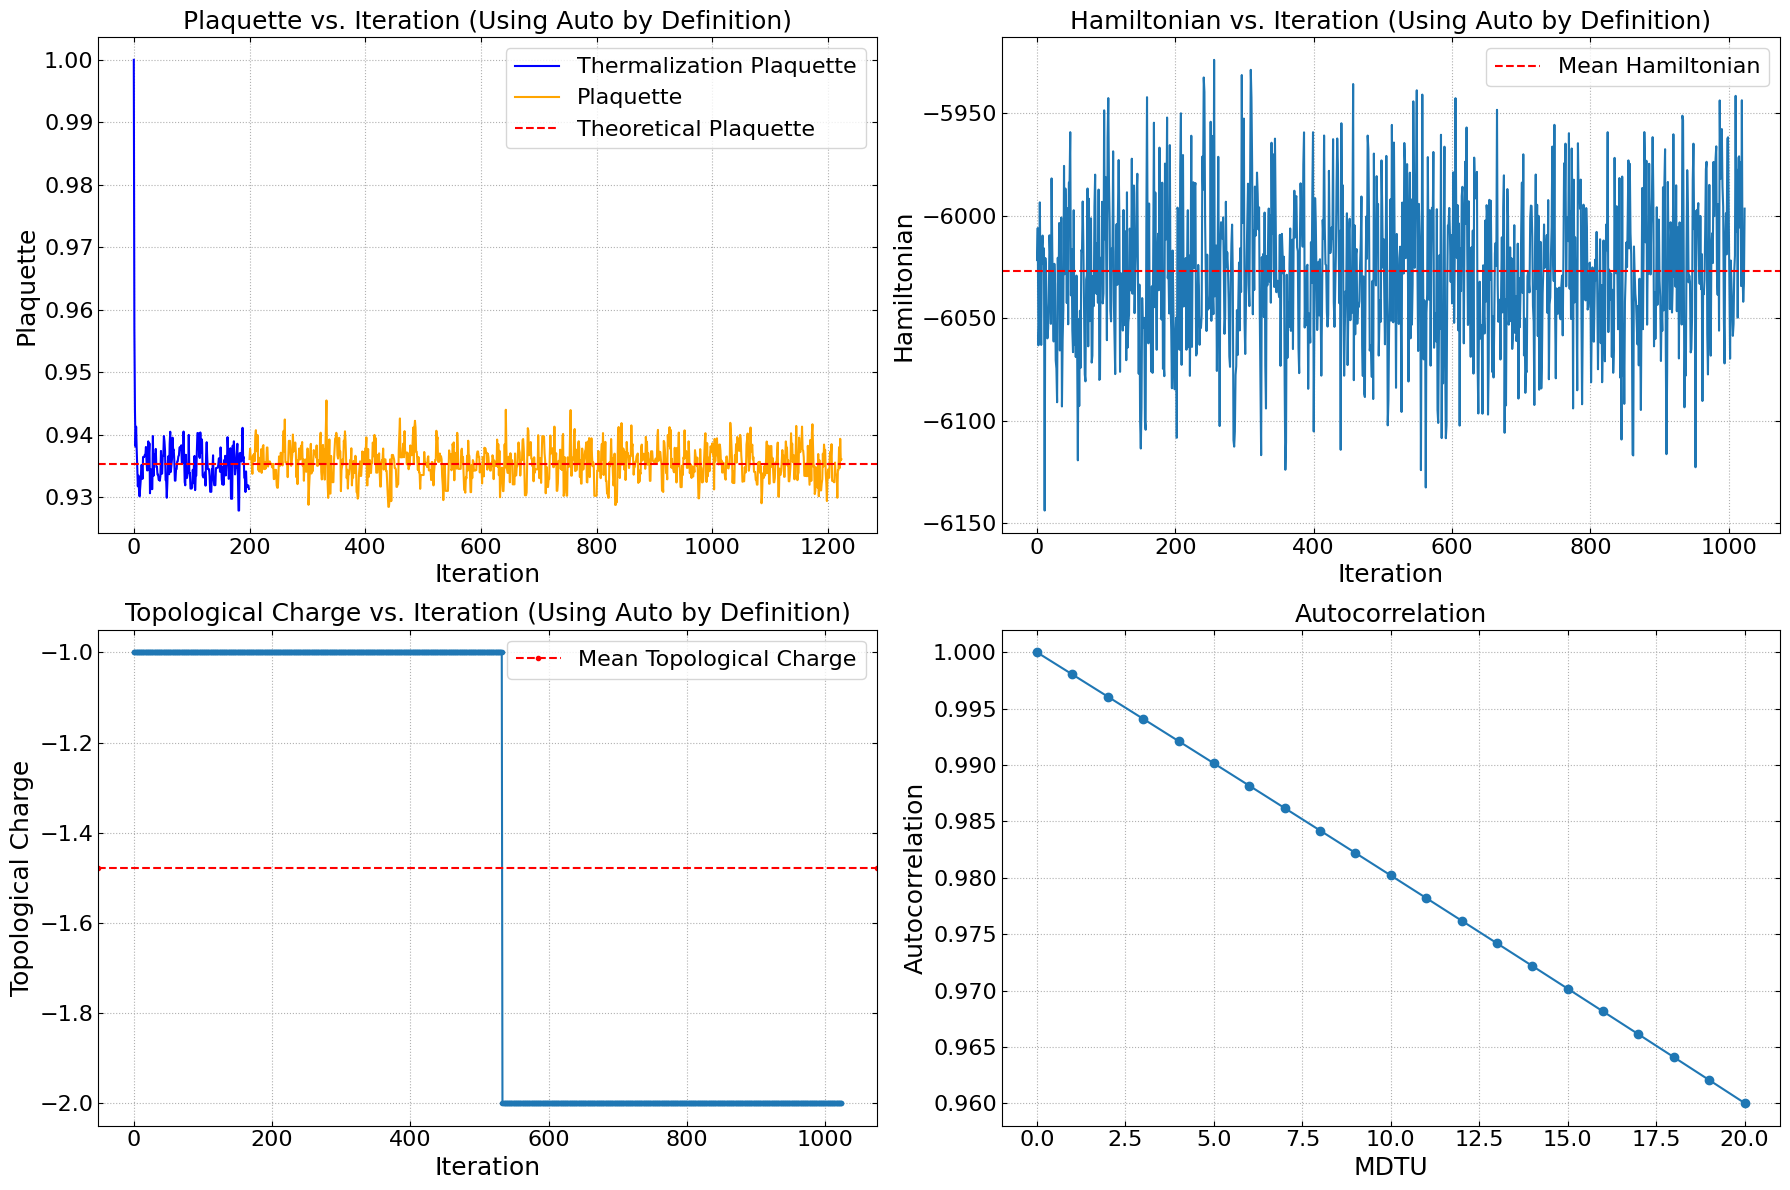

>>> Theoretical plaquette:  0.9352354935294382
>>> Mean plaq:  0.9354911776026711
>>> Std of mean plaq:  8.176081638620521e-05
Thermalization acceptance rate: 0.8000
Acceptance rate: 0.8232


In [4]:
print(">>> Neural Network Field Transformation HMC Simulation: ")

# initialize the field transformation
nn_ft = FieldTransformation(lattice_size, device=device, n_subsets=8, beta=beta, if_check_jac=False) #todo
# nn_ft.model.load_state_dict(torch.load('models/cnn_save.pt'), weights_only=False)

# load the data
data = np.load(f'dump/theta_ori_L{lattice_size}_beta{beta}.npy')
tensor_data = torch.from_numpy(data).float().to(device)
print(f"Loaded data shape: {tensor_data.shape}")

# split the data into training and testing
train_size = int(0.8 * len(tensor_data))
train_data = tensor_data[:train_size]
test_data = tensor_data[train_size:]
print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

# train the model
# if not os.path.exists(f'models/best_model_L{lattice_size}_beta{beta}.pt'): 
if True:
    print(">>> Training the model")
    nn_ft.train(train_data, test_data, beta, n_epochs=16, batch_size=32)

# Load the trained models
print(">>> Loading the trained models")
nn_ft._load_best_model()
print(">>> Models loaded successfully")


field_transformation = nn_ft.field_transformation
compute_jac_logdet = nn_ft.compute_jac_logdet

# Initialize HMC with field transformation
hmc = HMC_U1_FT(lattice_size, beta, n_thermalization_steps, n_steps, step_size, field_transformation=field_transformation, compute_jac_logdet=compute_jac_logdet, device=device)

# Thermalize the system
theta_thermalized, therm_plaq_ls, therm_acceptance_rate = hmc.thermalize()

# Run HMC without field transformation
final_config, plaq_ls, acceptance_rate, topological_charges, hamiltonians = hmc.run(n_iterations, theta_thermalized)

print(">>> Simulation completed")


# Compute autocorrelation of topological charges
max_lag = 20
hmc_fig = hmc_summary(beta, max_lag, volume, therm_plaq_ls, plaq_ls, topological_charges, hamiltonians, therm_acceptance_rate, acceptance_rate)
hmc_fig.savefig(f'plots/hmc_ft_L{lattice_size}_beta{beta}.pdf', transparent=True)
